# 목적

* Multi GPUs 환경에서 TensorFlow 2 모델 학습 템플릿 코드
* Custom 모델과 custom loss 를 사용할 수 있는 템플릿
* 환경: python 3.7

## 참고

텐서플로우 튜토리얼 공식 문서인
* [훈련 루프와 함께 tf.distribute.Strategy 사용하기](https://www.tensorflow.org/tutorials/distribute/custom_training?hl=ko)
* [텐서플로로 분산 훈련하기](https://www.tensorflow.org/guide/distributed_training)

를 참고하여 작성함

# 템플릿 코드 해설 

* 데이터 파일 위치

In [ ]:
# 카세트
path_eeg_fpz_cz_cs = '../data/eeg_fpz_cz.cs'
path_eeg_pz_oz_cs = '../data/eeg_pz_oz.cs'
# 텔레메트리
path_eeg_fpz_cz_tm = '../data/eeg_fpz_cz.tm'
path_eeg_pz_oz_tm = '../data/eeg_pz_oz.tm'

GPU 몇 번을 사용할지 

```python
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1,2'
```
위와 같이 세팅해주어야 안 쓰는 GPU 는 텐서플로우가 안쳐다봄

In [1]:
DEVICES = '0,1,2,3'
TF_DEVICES = []
for d in DEVICES.split(','):
    TF_DEVICES.append('/gpu:'+d)

In [2]:
import sys
sys.path.append("../utils")

import os
os.environ['CUDA_VISIBLE_DEVICES'] = DEVICES
import time

import tensorflow as tf
from tensorflow.keras import losses, metrics, optimizers
from data_loader import DataLoader # 데이터 불러오기 클래스
from models.classifier import Dcnn # 모델 클래스

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

이 예제에서는 MirroredStrategy 만 다룸

MirroredStrategy 의 개요
* 멀티 GPU 환경에서 각각의 GPU 에 모델을 복사하여 사용
* All reduce algorithm 으로 모델 파라미터 업데이트 (코드 짜는 사람은 동기화 어떻게 하는지 신경 쓸 필요 없음)

In [ ]:
# distributed training
strategy = tf.distribute.MirroredStrategy(devices=TF_DEVICES) # 어떤 GPU 쓸지 argument 로 줌
print(f'num of devices: {strategy.num_replicas_in_sync}')

In [ ]:
ETA = 1e-4 # learning rate
BATCH_SIZE = 2**10 # 각 GPU 에서 batch size
GLOBAL_BATCH_SIZE = BATCH_SIZE*strategy.num_replicas_in_sync # 모든 GPU 에 대한 총 batch size
EPOCHS = 150

Distributed training 은
```python
strategy.scope()
```
안에서 이루어져야 함

데이터 batch 에 대한 코드와 accuracy, loss 등에 관한 코드 몇 가지를 제외하고, 기존의 코드를 그대로 쓸 수 있음

아래에서 기존 코드와 다른 점은 **losses** 에 **reduction** argument

In [ ]:
with strategy.scope():
    # 모델 클래스 생성
    clf = Dcnn()
    clf.build(input_shape=(None,3000,1))
    
    # 데이터 로드 클래스 생성
    data_loader = DataLoader()
    
    # 옵티마이저와 로스 생성
    opt = optimizers.Adam(learning_rate=ETA)
    loss_object = losses.SparseCategoricalCrossentropy(reduction=losses.Reduction.NONE)
    
    test_loss = metrics.Mean(name='test_loss')
    train_accuracy = metrics.SparseCategoricalAccuracy(name='train_accuracy')
    test_accuracy = metrics.SparseCategoricalAccuracy(name='test_accuracy')
    
    # 각각 다른 모델 클래스에 관해 grads 를 구하고, apply gradients 를 하려면, 리스트에 넣어서 적용
    var_list = []
    var_list.extend(clf.trainable_variables)

트레이닝 단계에서 쓰이는 함수도 **strategy.scope()** 로 감싸줌

In [ ]:
with strategy.scope():
    
    def compute_loss(true,pred):
        # 문제 정의와 모델 구조에 따라 입맛에 맞게 고쳐 쓰자.
        per_example_loss = loss_object(true,pred)
        # 분산 환경에서 사용할 공통 코드
        return tf.nn.compute_average_loss(per_example_loss,global_batch_size=GLOBAL_BATCH_SIZE)
    
    # 문제 정의와 모델 구조에 따라 입맛에 맞게 고쳐 쓰자.
    def train_step(inputs):
        X, y = inputs
        
        with tf.GradientTape() as t:
            y_pred = clf(X)
            loss = compute_loss(y,y_pred)
        grads = t.gradient(loss, var_list)
        opt.apply_gradients(list(zip(grads, var_list)))
        
        train_accuracy.update_state(y,y_pred)
        return loss
    
    # 문제 정의와 모델 구조에 따라 입맛에 맞게 고쳐 쓰자.
    def test_step(inputs):
        X, y = inputs
        y_pred = clf(X)
        t_loss = loss_object(y,y_pred)
        test_loss.update_state(t_loss)
        test_accuracy.update_state(y,y_pred)
        
    # 분산 환경에서 사용할 공통 코드
    def distributed_train_step(dataset_inputs):
        per_replica_losses = strategy.experimental_run_v2(train_step,args=(dataset_inputs,))
        return strategy.reduce(tf.distribute.ReduceOp.SUM, per_replica_losses, axis=None)

    # 분산 환경에서 사용할 공통 코드
    def distributed_test_step(dataset_inputs):
        return strategy.experimental_run_v2(test_step, args=(dataset_inputs,))    

학습 과정도 **strategy.scope()** 로 감싸주어야 함

In [ ]:
with strategy.scope():
    # cross validation 할 횟수 만큼 seed 개수를 정해줌
    for seed in range(1):
        # seed 에 따라 다른 데이터 샘플을 불러옴
        X_train, y_train, X_valid, y_valid, X_test, y_test = data_loader(path_eeg_fpz_cz_cs, seed=seed, step=1)
        Max_train = np.max(X_train)
        Max_valid = np.max(X_valid)
        Max_test = np.max(X_test)
        X_train = np.squeeze(X_train,axis=1)/Max_train
        X_valid = np.squeeze(X_valid,axis=1)/Max_valid
        X_test = np.squeeze(X_test,axis=1)/Max_test
        
        # 데이터 길이마큼 shuffle 해줄 수 있도록 함
        BUFFER_SIZE = len(X_train)
        
        # shuffle 된 배치를 불러올 수 있도록 함
        # epoch 마다 shuffle 할 수 있도록 세팅 가능하므로 이걸 쓰는게 좋음
        train_dataset = tf.data.Dataset\
                        .from_tensor_slices((X_train,y_train))\
                        .shuffle(BUFFER_SIZE).batch(GLOBAL_BATCH_SIZE)
        # multi gpu 에서 데이터를 자동으로 나눠가지도록 함
        train_dist_dataset = strategy.experimental_distribute_dataset(train_dataset)
        
        # validation dataset 에 관해 위와 같은 역하
        valid_dataset = tf.data.Dataset\
                        .from_tensor_slices((X_valid,y_valid))\
                        .shuffle(BUFFER_SIZE).batch(GLOBAL_BATCH_SIZE)
        valid_dist_dataset = strategy.experimental_distribute_dataset(valid_dataset)
        
        
        for e in range(EPOCHS):
            start_time = time.time()
            
            num_batches = 0
            total_loss = .0
            for x in train_dist_dataset:
                total_loss += distributed_train_step(x)
                num_batches += 1
            train_loss = total_loss / num_batches
            
            for x in valid_dist_dataset:
                distributed_test_step(x)
                
            if (e+1)%10 == 0 or e == 0:
                print(f"{e+1}/{EPOCHS}, TRAIN: {train_loss:.8f}, {train_accuracy.result()*100:.2f}%, VALID: {test_loss.result():.8f}, {test_accuracy.result()*100:.2f}% {time.time() - start_time:.2f} sec/epoch")
            
            mean_time.append(time.time() - start_time)

            # loss, accuracy 를 리셋해줌
            test_loss.reset_states()
            train_accuracy.reset_states()
            test_accuracy.reset_states()

모델 inference 도 분산 환경에서 수행 가능

In [ ]:
%%time
test_dataset = tf.data.Dataset\
                .from_tensor_slices((X_test,y_test))\
                .shuffle(BUFFER_SIZE).batch(GLOBAL_BATCH_SIZE)
test_dist_dataset = strategy.experimental_distribute_dataset(test_dataset)

with strategy.scope():
    for x in test_dist_dataset:
        distributed_test_step(x)
print(f"TEST: {test_loss.result():.8f}, {test_accuracy.result()*100:.2f}%")
test_loss.reset_states()

# GPU 개수에 따른 모델 성능

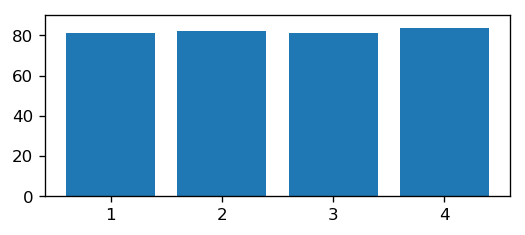

In [3]:
performance = [81.22,82.21,81.32,83.59]
xlabel = ['1','2','3','4']
x = np.arange(len(performance))
plt.figure(facecolor='w',figsize=(5,2),dpi=120)
plt.bar(x,performance)
plt.xticks(x,xlabel)
plt.ylim(0,90)
plt.show()

# GPU 개수에 따른 epoch 당 training 소요시간 평균
* 이 모델은 CPU 와 parameter 주고 받는 데 시간이 오래 더 오래 걸려서 아래와 같은 결과인듯

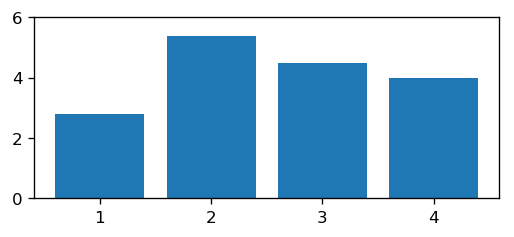

In [4]:
average = [2.80,5.39,4.49,3.97]
xlabel = ['1','2','3','4']
x = np.arange(len(performance))
plt.figure(facecolor='w',figsize=(5,2),dpi=120)
plt.bar(x,average)
plt.xticks(x,xlabel)
plt.ylim(0,6)
plt.show()